<a href="https://colab.research.google.com/github/sartansartan/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/ASartan_of_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html). Use the scaler's `fit_transform` method with the train set. Use the scaler's `transform` method with the test set.
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [37]:
df.tail()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
23035,4,OTHER,01 ONE FAMILY DWELLINGS,1,10965,276,NaN,A5,111-17 FRANCIS LEWIS BLVD,NaN,11429.0,1.0,0.0,1.0,"1,800",1224.0,1945.0,1,A5,510000,04/30/2019
23036,4,OTHER,09 COOPS - WALKUP APARTMENTS,2,169,29,NaN,C6,"45-14 43RD STREET, 3C",NaN,11104.0,0.0,0.0,0.0,0,0.0,1929.0,2,C6,355000,04/30/2019
23037,4,OTHER,10 COOPS - ELEVATOR APARTMENTS,2,131,4,NaN,D4,"50-05 43RD AVENUE, 3M",NaN,11377.0,0.0,0.0,0.0,0,0.0,1932.0,2,D4,375000,04/30/2019
23038,4,OTHER,02 TWO FAMILY DWELLINGS,1,8932,18,NaN,S2,91-10 JAMAICA AVE,NaN,11421.0,2.0,1.0,3.0,"2,078",2200.0,1931.0,1,S2,1100000,04/30/2019
23039,4,OTHER,12 CONDOS - WALKUP APARTMENTS,2,1216,1161,NaN,R2,"61-05 39TH AVENUE, F5",F5,11377.0,1.0,0.0,85.0,"15,151",854.0,1927.0,2,R2,569202,04/30/2019


In [0]:
df.drop('EASE-MENT', axis=1, inplace=True)

In [0]:
df.drop('APARTMENT_NUMBER', axis=1, inplace=True)

In [40]:
df.isnull().sum() 

BOROUGH                            0
NEIGHBORHOOD                       0
BUILDING_CLASS_CATEGORY            0
TAX_CLASS_AT_PRESENT               1
BLOCK                              0
LOT                                0
BUILDING_CLASS_AT_PRESENT          1
ADDRESS                            0
ZIP_CODE                           1
RESIDENTIAL_UNITS                  1
COMMERCIAL_UNITS                   1
TOTAL_UNITS                        1
LAND_SQUARE_FEET                  53
GROSS_SQUARE_FEET                  1
YEAR_BUILT                        35
TAX_CLASS_AT_TIME_OF_SALE          0
BUILDING_CLASS_AT_TIME_OF_SALE     0
SALE_PRICE                         0
SALE_DATE                          0
dtype: int64

In [0]:
df = df.dropna()

In [42]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
#Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' 
#and the sale price was more than 100 thousand and less than 2 million.

In [0]:
df_build = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS'] 
mask = (df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000)
df_sub = df_build.loc[mask]

In [45]:
df_sub.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [0]:
#Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [47]:
df_sub.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [48]:
df_sub['SALE_DATE'] = pd.to_datetime(df_sub['SALE_DATE'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
mask = (df_sub['SALE_DATE'] >= '2019-01-01') & (df_sub['SALE_DATE'] <= '2019-03-31')
train = df_sub.loc[mask]
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [50]:
mask = (df_sub['SALE_DATE'] >= '2019-04-01')
test = df_sub.loc[mask]
test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,A1,4616 INDEPENDENCE AVENUE,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01
18239,2,OTHER,01 ONE FAMILY DWELLINGS,1,5488,48,A2,558 ELLSWORTH AVENUE,10465.0,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,2019-04-01
18244,3,OTHER,01 ONE FAMILY DWELLINGS,1,5936,31,A1,16 BAY RIDGE PARKWAY,11209.0,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,2019-04-01
18280,3,OTHER,01 ONE FAMILY DWELLINGS,1,7813,24,A5,1247 EAST 40TH STREET,11210.0,1.0,0.0,1.0,"1,305",1520.0,1915.0,1,A5,789000,2019-04-01
18285,3,OTHER,01 ONE FAMILY DWELLINGS,1,8831,160,A9,2314 PLUMB 2ND STREET,11229.0,1.0,0.0,1.0,"1,800",840.0,1925.0,1,A9,525000,2019-04-01


In [0]:
#Do one-hot encoding of categorical features.

In [52]:
train.select_dtypes(exclude='number').describe().T

,count,unique,top,freq,first,last
BOROUGH,2517,5,4,1209,NaT,NaT
NEIGHBORHOOD,2517,6,OTHER,2390,NaT,NaT
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaT,NaT
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaT,NaT
ADDRESS,2517,2507,118-20 202ND STREET,2,NaT,NaT
LAND_SQUARE_FEET,2517,889,"4,000",235,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaT,NaT
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [53]:
train['LAND_SQUARE_FEET'] = train['LAND_SQUARE_FEET'].str.replace(r',', '').astype(int)
test['LAND_SQUARE_FEET'] = test['LAND_SQUARE_FEET'].str.replace(r',', '').astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [54]:
train.select_dtypes(exclude='number').describe().T

,count,unique,top,freq,first,last
BOROUGH,2517,5,4,1209,NaT,NaT
NEIGHBORHOOD,2517,6,OTHER,2390,NaT,NaT
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaT,NaT
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaT,NaT
ADDRESS,2517,2507,118-20 202ND STREET,2,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaT,NaT
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30


In [0]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'BUILDING_CLASS_CATEGORY', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [0]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [57]:
X_train.head()

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,0,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0


In [58]:
X_train.shape

(2517, 47)

In [0]:
#Do feature selection with SelectKBest.

In [71]:
from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func=f_regression, k=30)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(2517, 30)

In [72]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features Selected:')
for name in selected_names:
  print(name)

print('')
print('Features Not Selected:')
for name in unselected_names:
  print(name)

Features Selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BLOCK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_S0
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A4
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0

Features Not Selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRE

In [0]:
#Do feature scaling. Use the scaler's fit_transform method with the train set. 
#Use the scaler's transform method with the test set.

In [0]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [0]:
# Fit a ridge regression model with multiple features.

In [0]:
from sklearn.linear_model import Ridge

model = Ridge(alpha=150)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [0]:
#Get mean absolute error for the test set.

In [93]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
display((f'Test Mean Absolute Error: ${mae:,.0f}'))

'Test Mean Absolute Error: $158,235'

In [0]:
#Trying to improve results. How many features should be selected?

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns) + 1):
  print(f'{k} features:')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} \n')

1 features:
Test MAE: $185,788 

2 features:
Test MAE: $181,871 

3 features:
Test MAE: $181,603 

4 features:
Test MAE: $181,603 

5 features:
Test MAE: $173,029 

6 features:
Test MAE: $172,716 

7 features:
Test MAE: $170,678 

8 features:
Test MAE: $170,774 

9 features:
Test MAE: $170,403 

10 features:
Test MAE: $167,304 

11 features:
Test MAE: $157,646 

12 features:


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $157,200 

13 features:
Test MAE: $157,890 

14 features:
Test MAE: $159,653 

15 features:
Test MAE: $159,742 

16 features:
Test MAE: $159,744 

17 features:
Test MAE: $159,584 

18 features:
Test MAE: $159,584 

19 features:
Test MAE: $159,408 

20 features:
Test MAE: $159,408 

21 features:


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $159,494 

22 features:
Test MAE: $159,494 

23 features:
Test MAE: $157,291 

24 features:
Test MAE: $157,291 

25 features:
Test MAE: $157,291 

26 features:
Test MAE: $157,291 

27 features:
Test MAE: $156,989 

28 features:
Test MAE: $156,855 

29 features:
Test MAE: $156,780 

30 features:


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $156,731 

31 features:
Test MAE: $157,912 

32 features:
Test MAE: $157,928 

33 features:
Test MAE: $157,856 

34 features:
Test MAE: $157,849 

35 features:
Test MAE: $157,837 

36 features:
Test MAE: $158,800 

37 features:
Test MAE: $158,917 

38 features:
Test MAE: $158,985 

39 features:


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $158,856 

40 features:
Test MAE: $158,856 

41 features:
Test MAE: $158,839 

42 features:
Test MAE: $158,813 

43 features:
Test MAE: $158,810 

44 features:
Test MAE: $159,035 

45 features:
Test MAE: $159,035 

46 features:
Test MAE: $159,002 

47 features:
Test MAE: $159,087 



/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return

In [0]:
#Updating feature selection to 30. Now, what should be our alpha?

In [80]:
from sklearn.metrics import mean_squared_error

alphas = []
mses = []

for alpha in range(1, 1000, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

1 53473830417.88124
2 53479022463.38837
3 53500043651.492546
4 53529012813.515465
5 53562353190.71929
6 53597956768.23458
7 53634509375.50549
8 53671179111.52011
9 53707439306.79336
10 53742960631.08672
11 53777543103.981865
12 53811072303.09607
13 53843490678.18643
14 53874778499.42672
15 53904941059.81957
16 53934000000.18369
17 53961987388.39516
18 53988941660.53409
19 54014904833.66329
20 54039920594.73254
21 54064032997.52153
22 54087285583.991875
23 54109720803.09778
24 54131379638.56355
25 54152301383.4986
26 54172523517.96462
27 54192081658.341835
28 54211009556.289665
29 54229339131.442116
30 54247100526.488235
31 54264322176.525406
32 54281030886.89837
33 54297251915.416245
34 54313009056.05462
35 54328324722.1326
36 54343220027.594124
37 54357714865.48369
38 54371827983.046104
39 54385577053.117004
40 54398978741.64688
41 54412048771.32081
42 54424801981.32344
43 54437252383.354195
44 54449413214.03883
45 54461296983.90461
46 54472915523.10024
47 54484280024.04913
48 5449540

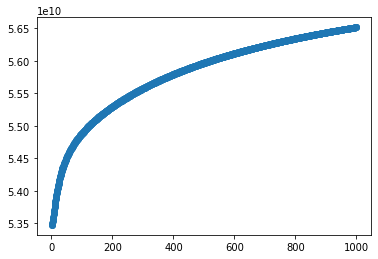

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);

In [0]:
#I guess alpha should be around 150?